In [1]:
%matplotlib inline

In [2]:
#Libraries used 
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

## Downloading Bees and Ants data

In [3]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2021-12-15 13:34:51--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.85.79.74, 52.85.79.23, 52.85.79.49, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.85.79.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  60.8MB/s    in 0.7s    

2021-12-15 13:34:52 (60.8 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/

## Data Augmentation and Normalization

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
print(dataset_sizes)

{'train': 244, 'val': 153}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


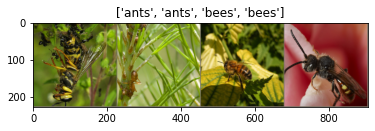

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
print(inputs,classes)

tensor([[[[-0.7650, -0.7308, -0.7479,  ...,  0.8789,  0.3309, -0.5253],
          [-0.9877, -0.9877, -0.9534,  ...,  1.1015,  0.6049, -0.3198],
          [-1.1075, -1.0390, -0.9363,  ...,  0.7419,  0.4851, -0.0801],
          ...,
          [-0.7993, -0.7993, -0.7650,  ..., -0.8849, -0.7993, -0.7650],
          [-0.7650, -0.7993, -0.7822,  ..., -0.8164, -0.7993, -0.7822],
          [-0.9020, -0.8335, -0.8164,  ..., -0.7993, -0.7822, -0.7308]],

         [[-0.2150, -0.2850, -0.3901,  ...,  1.3782,  0.8529, -0.0574],
          [-0.4426, -0.4951, -0.5126,  ...,  1.4482,  1.0805,  0.1702],
          [-0.5476, -0.5651, -0.4951,  ...,  0.9930,  0.8880,  0.3452],
          ...,
          [ 0.0301, -0.0224, -0.0049,  ..., -0.6352, -0.6001, -0.5826],
          [ 0.0476,  0.0476,  0.0301,  ..., -0.5826, -0.5651, -0.5651],
          [ 0.0126,  0.0301,  0.0476,  ..., -0.5651, -0.5301, -0.4601]],

         [[-1.7522, -1.6302, -1.5256,  ...,  0.0256, -0.0092, -0.7587],
          [-1.7870, -1.6824, -

In [8]:
inputs.size()

torch.Size([4, 3, 224, 224])

## Defining Model 

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # calling scheduler
                    if phase == 'train':
                        scheduler.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Fine-tuning by adding last new layer

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6295 Acc: 0.6557
val Loss: 0.5685 Acc: 0.7386

Epoch 1/24
----------
train Loss: 0.6134 Acc: 0.6598
val Loss: 0.5548 Acc: 0.7516

Epoch 2/24
----------
train Loss: 0.6062 Acc: 0.6885
val Loss: 0.5581 Acc: 0.7320

Epoch 3/24
----------
train Loss: 0.6070 Acc: 0.6926
val Loss: 0.5475 Acc: 0.7516

Epoch 4/24
----------
train Loss: 0.5972 Acc: 0.7172
val Loss: 0.5506 Acc: 0.7451

Epoch 5/24
----------
train Loss: 0.5890 Acc: 0.6844
val Loss: 0.5708 Acc: 0.7320

Epoch 6/24
----------
train Loss: 0.6267 Acc: 0.6598
val Loss: 0.5502 Acc: 0.7451

Epoch 7/24
----------
train Loss: 0.5978 Acc: 0.6967
val Loss: 0.5536 Acc: 0.7451

Epoch 8/24
----------
train Loss: 0.6070 Acc: 0.6721
val Loss: 0.5671 Acc: 0.7386

Epoch 9/24
----------
train Loss: 0.5768 Acc: 0.7418
val Loss: 0.5432 Acc: 0.7647

Epoch 10/24
----------
train Loss: 0.6053 Acc: 0.6844
val Loss: 0.5515 Acc: 0.7451

Epoch 11/24
----------
train Loss: 0.6113 Acc: 0.6639
val Loss: 0.5564 Acc: 0.7320

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


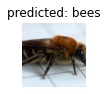

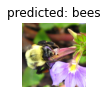

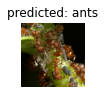

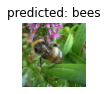

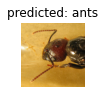

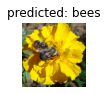

In [ ]:
visualize_model(model_ft)

In [ ]:
!pip install torchinfo

In [ ]:
from torchsummary import summary
model = model_ft
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## Fine-tuning by freezing the weights

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters(): #By switching the requires_grad flags to False, no intermediate buffers will be saved.
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2) # Constructing new last layer

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.0055 Acc: 0.4672
val Loss: 0.7714 Acc: 0.5752

Epoch 1/24
----------
train Loss: 0.8897 Acc: 0.5000
val Loss: 0.8042 Acc: 0.5752

Epoch 2/24
----------
train Loss: 0.8990 Acc: 0.5000
val Loss: 0.8068 Acc: 0.5817

Epoch 3/24
----------
train Loss: 0.8875 Acc: 0.5041
val Loss: 0.8026 Acc: 0.5752

Epoch 4/24
----------
train Loss: 0.8749 Acc: 0.5000
val Loss: 0.7935 Acc: 0.5752

Epoch 5/24
----------
train Loss: 0.8750 Acc: 0.5000
val Loss: 0.8295 Acc: 0.5621

Epoch 6/24
----------
train Loss: 0.8729 Acc: 0.4959
val Loss: 0.7983 Acc: 0.5686

Epoch 7/24
----------
train Loss: 0.8829 Acc: 0.4959
val Loss: 0.8086 Acc: 0.5686

Epoch 8/24
----------
train Loss: 0.8952 Acc: 0.5000
val Loss: 0.7661 Acc: 0.5752

Epoch 9/24
----------
train Loss: 0.8946 Acc: 0.4959
val Loss: 0.7672 Acc: 0.5817

Epoch 10/24
----------
train Loss: 0.8507 Acc: 0.5000
val Loss: 0.8049 Acc: 0.5621

Epoch 11/24
----------
train Loss: 0.8878 Acc: 0.5041
val Loss: 0.7852 Acc: 0.5752

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


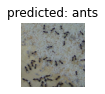

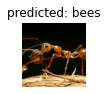

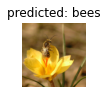

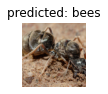

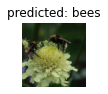

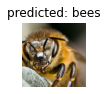

In [ ]:
visualize_model(model_conv)

In [ ]:
print(summary(model_conv,(3,224,224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## Fine-tuning by freezing first 6 layers 

In [11]:
model_new = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [12]:
count = 0
for child in model_new.children():
    count+=1
print(count) # total layers

10


In [13]:
count = 0 # freezing first 6 layers
for child in model_new.children():
  count+=1
  if count < 7:
    for param in child.parameters():
        param.requires_grad = False

In [20]:
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_new.fc.in_features
model_new.fc = nn.Linear(num_ftrs, 2) # Constructing new last layer

model_new = model_new.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of layers which are not freeze are being optimized as
# opposed to before.
optimizer_new = optim.SGD(filter(lambda p: p.requires_grad, model_new.parameters()), lr=0.001,momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_new, step_size=7, gamma=0.1)

In [21]:
model_new = train_model(model_new, criterion, optimizer_new,
                         exp_lr_scheduler, num_epochs=25)    # training the model

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6131 Acc: 0.6967
val Loss: 0.5549 Acc: 0.7451

Epoch 1/24
----------
train Loss: 0.6106 Acc: 0.6803
val Loss: 0.5799 Acc: 0.7124

Epoch 2/24
----------
train Loss: 0.6025 Acc: 0.7049
val Loss: 0.5488 Acc: 0.7516

Epoch 3/24
----------
train Loss: 0.6100 Acc: 0.7090
val Loss: 0.5652 Acc: 0.7386

Epoch 4/24
----------
train Loss: 0.6304 Acc: 0.6639
val Loss: 0.5503 Acc: 0.7320

Epoch 5/24
----------
train Loss: 0.6052 Acc: 0.6926
val Loss: 0.5764 Acc: 0.7190

Epoch 6/24
----------
train Loss: 0.6222 Acc: 0.6475
val Loss: 0.5672 Acc: 0.6928

Epoch 7/24
----------
train Loss: 0.6030 Acc: 0.6926
val Loss: 0.5395 Acc: 0.7712

Epoch 8/24
----------
train Loss: 0.6175 Acc: 0.6557
val Loss: 0.5882 Acc: 0.7190

Epoch 9/24
----------
train Loss: 0.6241 Acc: 0.6721
val Loss: 0.5717 Acc: 0.7124

Epoch 10/24
----------
train Loss: 0.6044 Acc: 0.6967
val Loss: 0.5568 Acc: 0.7320

Epoch 11/24
----------
train Loss: 0.5853 Acc: 0.7336
val Loss: 0.5822 Acc: 0.6993

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


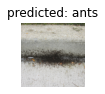

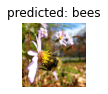

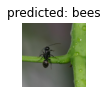

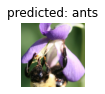

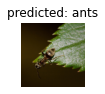

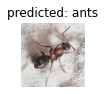

In [22]:
visualize_model(model_new)

In [19]:
from torchsummary import summary
print(summary(model_new,(3,224,224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,